## Dynamic Parallel Flux Balance Analysis (dpFBA) 

[***Dynamic Flux Balance Analysis*** (`dFBA`)](https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/iet-syb.2013.0021) is a computational method that combines Flux Balance Analysis (FBA) with dynamic modeling to simulate the behavior of biological systems over time. It extends the capabilities of FBA, which analyzes metabolic networks at a single time point, to track changes in metabolite concentrations and fluxes in response to environmental conditions and cellular processes. 

dFBA simulates the interaction between a cell's internal metabolic network and its external environment over time. 
It couples a dynamic system, describing the extracellular environment, with an optimization problem, representing the intracellular metabolic network. 

There are two basic implementations of dFBA for cellular communities. The first approach, called *joint dFBA* (jdFBA), requires the establishment of a community model. Strictly put, the community model represents the combined stoichiometric matrices of n GEMs, and a community biomass is defined as the total sum of individual biomasses. The formation of this species is then set as the objective function.

The key idea of the second approach, called *dynamic parallel FBA* (dpFBA), is to perform dFBA on individual models while keeping track of the shared pool of external metabolites from which all models can take up nutrients. The concentrations of each biomass and of the external metabolites is updated at each time interval.


*Implementation*:

Several implementations of dpFBA are available. This notebook shows a simple example of implementing dpFBA using COBRApy and Scipy [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) in the so-called ***static optimization approach*** ([`SOA`](https://www.sciencedirect.com/science/article/pii/S0006349502739039)).


In [1]:
import numpy as np
from tqdm import tqdm
import cobra
from cobra.io import load_model
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

### Set up the dynamic system

Dynamic flux balance analysis couples a dynamic system in external cellular concentrations to a pseudo-steady state metabolic model.

Here, we define the function `add_dynamic_bounds(model, y)` to convert the external metabolite concentrations into bounds on the boundary fluxes in the metabolic model. We use a single flux determination for all the metabolites.

In [2]:
model1 = load_model('textbook')

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-06


In [3]:
def add_dynamic_bounds_1(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    

In [4]:
def dynamic_system_1(t, y):
    """Calculate the time derivative of external species."""

    global feasibility_1

    biomass, glucose = y  # expand the boundary species
    n_fluxes = len(y)

    # Calculate the specific exchanges fluxes at the given external concentrations.    
    with model1 as model:
        add_dynamic_bounds_1(model, y)

        model.slim_optimize()

        if model.solver.status == 'optimal':
            inner_sol_1 = model.optimize()
            fluxes = inner_sol_1.fluxes.get(['Biomass_Ecoli_core', 'EX_glc__D_e']).values
            fluxes *= biomass
            feasibility_1 = -1.0
        else:
            fluxes = np.zeros(n_fluxes)
            feasibility_1 = 0.0

    # Here we display the current
    # simulation time using a progress bar.
    if dynamic_system_1.pbar is not None:
        dynamic_system_1.pbar.update(1)
        dynamic_system_1.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes


def infeasible_event_1(t, y):
    """
    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function just passes the infeasible variable calculated by dynamic_system_1.
    """
    
    return feasibility_1      


dynamic_system_1.pbar = None

    

In [5]:
# Model1    
infeasible_event_1.direction = 1
infeasible_event_1.terminal = True # Set to False to continue simulation after an infeasible event

#### Run the dynamic FBA simulation with continuous integration

In [6]:
ts = np.linspace(0, 8, 800)  # Desired integration resolution and interval
y0 = [0.1, 10] # Initial conditions for biomass and glucose

with tqdm() as pbar:
    dynamic_system_1.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system_1,
        events=[infeasible_event_1],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        # t_eval=ts,
        method='BDF'
    )

t = 5.822: : 102it [00:01, 57.74it/s]


Because the culture runs out of glucose, the simulation terminates early. The exact time of this 'cell death' is recorded in `sol.t_events`.

#### Plot timelines of biomass and glucose with continuous integration.

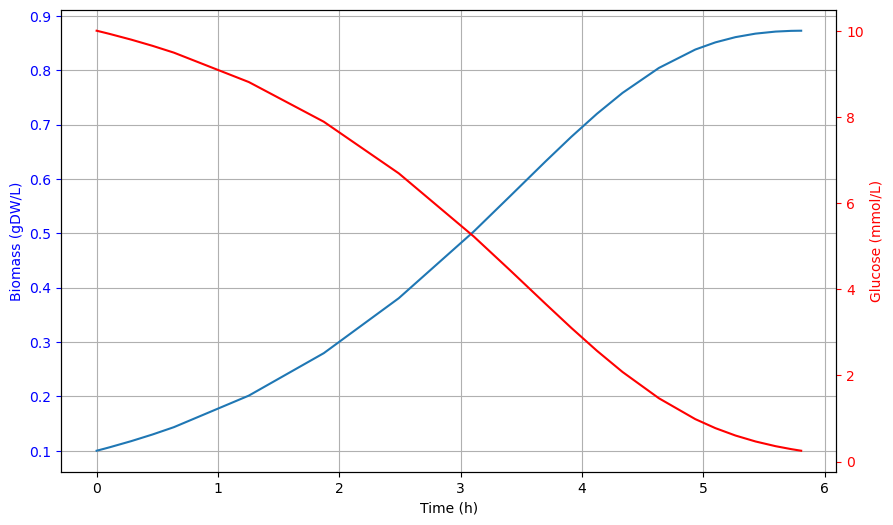

In [7]:
fig,ax = plt.subplots(figsize=(10,6))
# make ax ticks and numbers blue
ax.tick_params(axis='y', colors='b')
ax.plot(sol.t, sol.y.T[:, 0])
# 
ax2 = plt.twinx(ax)
# make ax2 ticks and numbers red
ax2.tick_params(axis='y', colors='r')
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass (gDW/L)', color='b')
ax2.set_ylabel('Glucose (mmol/L)', color='r')
ax.set_xlabel('Time (h)')
ax.grid()

plt.show()

### dFBA with $\Delta (t)$ updates on extracellular metabolites, using a range of $\Delta (t) = [0.01,0.05,0.2,1.0]$

In [8]:
delta_t_vec = [0.01,0.05,0.2,1.0][::-1]
niter_vec = [1000,200,40,8][::-1]
solutions = {}

# Prepare the initial conditions for the two models.
for i, (delta_t, niter) in enumerate(zip(delta_t_vec, niter_vec)):

    mass_global = np.zeros((niter+1))
    glucose_global = np.zeros(niter+1)

    sol1_global = np.zeros((2,niter+1))
    sol_status_global = np.zeros((niter+1))


    # Initial conditions
    y0_1_mass = 0.1
    y0_glucose = 10

    y0_1 = [y0_1_mass, y0_glucose] # Initial conditions for biomass, glucose 

    # Initialize global solutions with initial conditions
    sol1_global[:, 0] = y0  # Initial conditions for biomass, glucose
    sol_status_global[0] = 0  # Initial status: 0 means successful integration, 1 means event triggered

    # Initialize global concentrations with initial conditions for each concentration calculated explicitly
    mass_global[0] = y0_1_mass
    glucose_global[0] = y0_glucose

    t_global = [0]

    for iter in tqdm(range(niter)):
        
        ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

        if iter>0 and sol_status_global[iter-1] == 1:
            pass
        else:

            with model1 as model:

                sol1 = solve_ivp(
                    fun=dynamic_system_1,
                    events=[infeasible_event_1],
                    t_span=(ts.min(), ts.max()),
                    y0=y0_1,
                    t_eval=ts,
                    method='RK45'
                )

        # Store the time points
        t_global.append(t_global[-1] + delta_t)            

        # Store the individual solutions in the global solutions
        sol1_global[:, iter+1] = sol1['y'][:, -1]
        sol_status_global[iter+1] = sol1['status']

        # Update the masses
        y0_1_mass = sol1['y'][0, -1]

        # Update the glucose concentration adding to the initial value
        # the changes for production or consumption. If there were multiple 
        # compartments, we would need to sum all the contributions.
        d1_glucose = sol1['y'][1,-1]-sol1['y'][1,0]
        y0_glucose = y0_glucose + d1_glucose

        # Update the initial conditions for both strains
        y0_1 = [y0_1_mass, y0_glucose]
        
        # Store the results in the global solutions
        mass_global[iter+1] = y0_1_mass
        glucose_global[iter+1] = y0_glucose        

        # Stop the simulation if solution is infeasible
        # if sol1['status'] == 1:
        #     print(f"Solution is infeasible")
        #     break

        # Same as above but using the feasibility variable
        if feasibility_1 == 0:
            print(f"Solution is infeasible")
            break

    # Update solution dictionary
    solutions[delta_t] = {'time': t_global, 'mass': mass_global, 'glucose': glucose_global, 'status': sol_status_global}


 62%|██████▎   | 5/8 [00:00<00:00, 10.33it/s]


Solution is infeasible


 72%|███████▎  | 29/40 [00:01<00:00, 15.97it/s]


Solution is infeasible


 58%|█████▊    | 116/200 [00:04<00:03, 24.61it/s]


Solution is infeasible


 58%|█████▊    | 580/1000 [00:41<00:30, 13.90it/s]

Solution is infeasible


#### Plot timelines of biomass, glucose: compare discretized integration (with RK45) to continuous integration (with BDF).

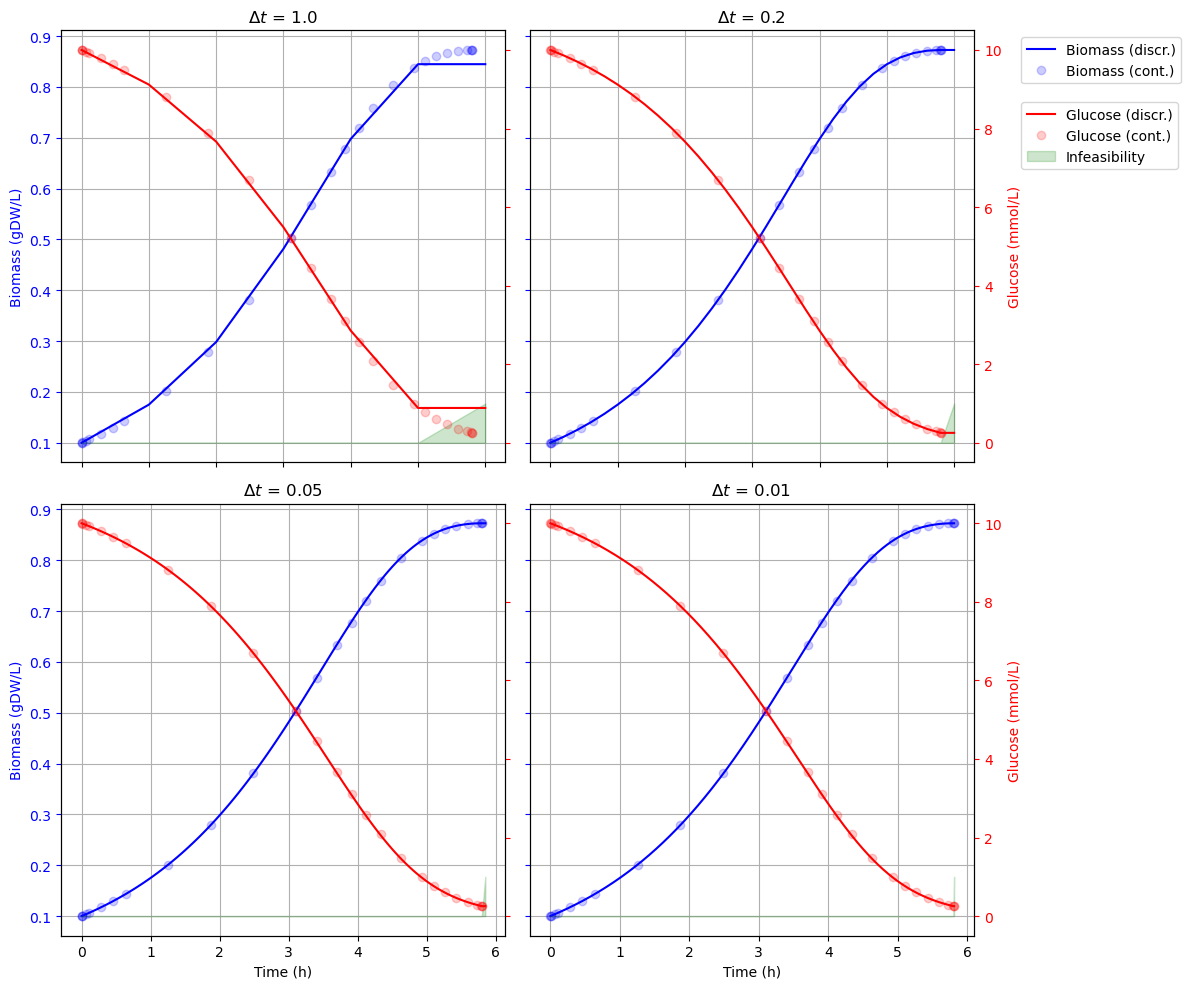

In [9]:
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax2 = np.empty((2, 2), dtype=object)  # Create a 2x2 array to store secondary axes

axes = [(0,0), (0,1), (1,0), (1,1)]
skip = 1

for iax, solution in enumerate(solutions):

    mass_global = solutions[solution]['mass']
    glucose_global = solutions[solution]['glucose']
    sol_status_global = solutions[solution]['status']
    n_t = len(solutions[solution]['time'])
    t = solutions[solution]['time']

    i, j = axes[iax]
    ax[i, j].tick_params(axis='y', colors='b')
    ax[i, j].tick_params(axis='x', colors='k')
    ax2[i, j] = ax[i, j].twinx()  # Use the twinx() method of the axes object
    ax2[i, j].tick_params(axis='y', colors='r')

    if iax == 1:
        ax[i, j].plot(t, mass_global[:n_t], label='Biomass (discr.)', color='b')
        ax2[i, j].plot(t, glucose_global[:n_t], label='Glucose (discr.)', color='r')
        # Plot continuous integration results only every 'skip' points (all points if 'skip'=1)
        ax[i, j].plot(sol.t[::skip], sol.y.T[::skip, 0], 'ob', label='Biomass (cont.)', alpha=0.2)
        ax2[i, j].plot(sol.t[::skip], sol.y.T[::skip, 1], 'or', label='Glucose (cont.)', alpha=0.2)
        ax2[i, j].fill_between(t, 0, sol_status_global[:n_t], color='g', alpha=0.2, label='Infeasibility')        
    else:
        ax[i, j].plot(t, mass_global[:n_t], color='b')
        ax2[i, j].plot(t, glucose_global[:n_t], color='r')
        ax[i, j].plot(sol.t[::skip], sol.y.T[::skip, 0], 'ob', alpha=0.2)
        ax2[i, j].plot(sol.t[::skip], sol.y.T[::skip, 1], 'or', alpha=0.2)
        ax2[i, j].fill_between(t, 0, sol_status_global[:n_t], color='g', alpha=0.2)

    if iax == 0 or iax == 1:
        ax[i, j].set_xticklabels([])

    if iax == 0 or iax == 2:
        ax[i, j].set_ylabel('Biomass (gDW/L)', color='b')
        ax2[i, j].set_yticklabels([])

    if iax == 1 or iax == 3:
        ax2[i, j].set_ylabel('Glucose (mmol/L)', color='r')
        ax[i, j].set_yticklabels([])

    if iax == 2 or iax == 3:
        ax[i, j].set_xlabel('Time (h)', color='k')

    if iax == 1:
        ax[i, j].legend(bbox_to_anchor=(1.09, 1.00), loc='upper left')
        ax2[i, j].legend(bbox_to_anchor=(1.09, 0.85), loc='upper left')        

    ax[i, j].grid()
    ax[i, j].title.set_text('$\Delta t$ = {} '.format(delta_t_vec[i*2+j]) )

    # bring panels tighter together
    fig.tight_layout()

plt.show()